In [1]:
import pandas as pd
from dateparser.search import search_dates
import seaborn as sns
import glob
from tabula import read_pdf
import numpy as np

dataf = 'Data/SDcountySituation-{}.csv'
locf = 'Data/SDcountyLocations-{}.csv'
zipf = 'Data/SDcountyZipcodes-{}.csv'

tab_hist = {}

In [3]:

# I used wayback machine to collect the county data for the 
# dates before I began this project, starting with first day over 100 cases
'''get_historical_data = [
    'https://web.archive.org/web/20200320184055/https://www.sandiegocounty.gov/content/sdc/hhsa/programs/phs/community_epidemiology/dc/2019-nCoV/status.html',
    'https://web.archive.org/web/20200321141257/https://www.sandiegocounty.gov/content/sdc/hhsa/programs/phs/community_epidemiology/dc/2019-nCoV/status.html',
    'https://web.archive.org/web/20200322080211/https://www.sandiegocounty.gov/content/sdc/hhsa/programs/phs/community_epidemiology/dc/2019-nCoV/status.html',
    'https://web.archive.org/web/20200323094801/https://www.sandiegocounty.gov/content/sdc/hhsa/programs/phs/community_epidemiology/dc/2019-nCoV/status.html',
    'https://web.archive.org/web/20200324003021/https://www.sandiegocounty.gov/content/sdc/hhsa/programs/phs/community_epidemiology/dc/2019-nCoV/status.html'
]

for link in get_historical_data:
    tab = pd.read_html(link)
    #comes down as a list of each column seperately, with the header the same in each column-table
    table = tab[2].drop(0)
    # setup header and index
    cs =  table.iloc[0,:].to_list()
    cs[0] = 'index'
    table.columns = cs
    table = table.drop(1).set_index('index')
    # get todays date from that header we threw away on each column
    dt = search_dates(tab[2].iloc[0,0])[-1][1]
    today = dt.strftime('%Y-%m-%d')
    # theres some variability in nomenclature to deal with from day to day
    idx = table.index.to_series()
    idx[ 'Hospitalized' == idx ] = 'Hospitalizations'
    table.index = idx
    if not 'Intensive Care' in idx:
        table.loc['Intensive Care',:] = 0
        
    print(today)
    # record todays data for posterity
    table.to_csv(dataf.format(today))
    tab_hist[today] = table
    ''';

# From now on we can just load the data that's already in the repo
files = glob.glob('Data/SDcountySituation*.csv') # gets all .csv filenames in directory
for afile in files:
    dt = afile.split('/')[1][18:28]
    print(dt)
    tab_hist[dt] = pd.read_csv(afile,index_col=0,header=0)

2020-03-28
2020-03-29
2020-03-22
2020-04-03
2020-04-02
2020-03-23
2020-03-21
2020-04-01
2020-03-20
2020-04-05
2020-03-30
2020-03-24
2020-03-25
2020-03-31
2020-03-19
2020-04-04
2020-03-27
2020-03-26


In [358]:
# Run me every day! Website updates once a day at around 4pm
tab = pd.read_html('https://www.sandiegocounty.gov/content/sdc/hhsa/programs/phs/community_epidemiology/dc/2019-nCoV/status.html')
#comes down as a list of each column seperately, with the header the same in each column-table
tabs = [ x.drop(0) for x in tab]
table = pd.concat(tabs)
# setup header and index
cs =  table.iloc[0,:].to_list()
cs[0] = 'index'
table.columns = cs
table = table.drop(1).set_index('index')
# get todays date from that header we threw away on each column
# great, they've updated the format again and now it says 
#"updated Date X with data through Date X-1"
# it's like they're trying to make it harder for me by changing something every day!
# need to go back to Date X format for consistency with previous data
# OLD: dt = search_dates(tab[0][0][0])[-1][1]
dt = search_dates(tab[0][0][0])[-2][1]
today = dt.strftime('%Y-%m-%d')


In [359]:
# Sstarting 26 March the Total and non-county residents columns disappeared
# and everythign is under San Diego County Residents, even though I believe that is actually the Total column
# if i'm wrong this generates a discontinuity of 20 non-resident cases, making the growth from 25 - 26 March look
# smaller than it is, it will lead to an underestimate of the exponential coefficient
# Update: I was wrong. There is an underestimate of the early doubling time built into the data.  Now after a few days of seeing county briefs I understand that thye changed how they count... people's registered address with DMV is used to count the numbers... not where they actually lived or where they visited the hospital.
# and each jurisdiction is now only counting its residents (in this sense of the word), not the people in its hospitals

table.columns=['Total']

# record todays data for posterity
table.to_csv(dataf.format(today))
tab_hist[today] = table
print(today)
table

2020-04-10


,Total
index,
Total Positives,1693
Age Groups,NaN
0-9 years,10
10-19 years,21
20-29 years,264
30-39 years,335
40-49 years,292
50-59 years,305
60-69 years,235


In [360]:
cases = pd.Series({key:int(value.loc['Total Positives','Total']) for key,value in tab_hist.items()}).sort_index()
hospitalizations = pd.Series({key:int(value.loc['Hospitalizations','Total']) for key,value in tab_hist.items()}).sort_index()
icu = pd.Series({key:int(value.loc['Intensive Care','Total']) for key,value in tab_hist.items()}).sort_index()
deaths = pd.Series({key:int(value.loc['Deaths','Total']) for key,value in tab_hist.items()}).sort_index()
totals = pd.DataFrame( {'Confirmed cases':cases, 'Hospitalizations':hospitalizations, 'ICU patients':icu, 'Deaths':deaths})

In [361]:
sns.set_style('darkgrid')
colors = sns.color_palette()
import matplotlib.pyplot as plt

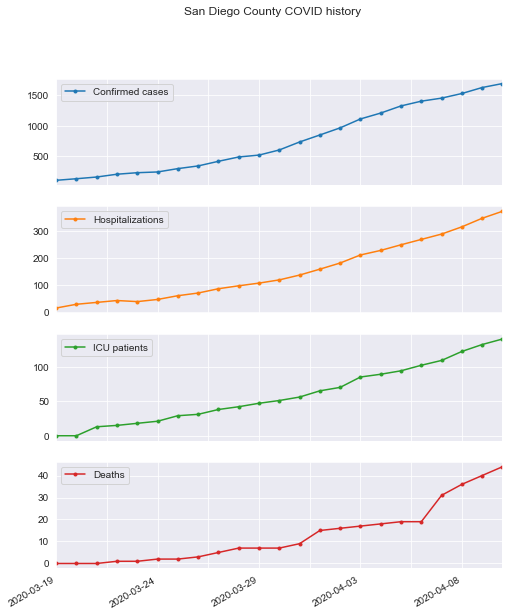

In [362]:
totals.plot(subplots=True,sharex=True,figsize=(8,10),marker='.')
plt.suptitle('San Diego County COVID history')
plt.savefig('Plots/chistory.png',dpi=300);

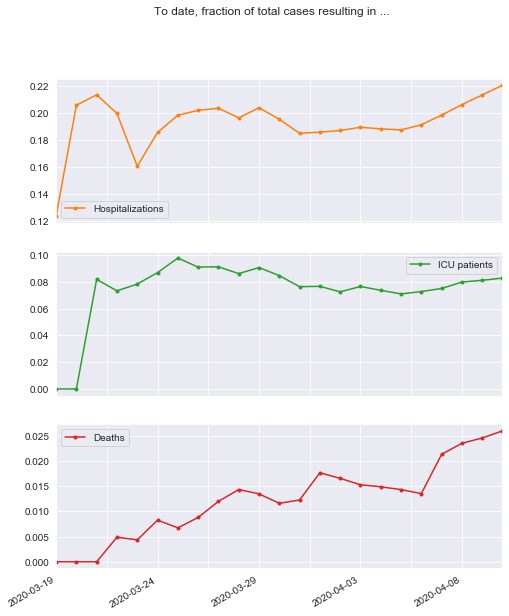

In [363]:
frac = totals[['Hospitalizations','ICU patients','Deaths']]
frac = frac.apply(lambda x: x/totals['Confirmed cases'])
frac.plot(subplots=True,sharex=True,figsize=(8,10),marker='.',color=colors[1:]);
plt.suptitle('To date, fraction of total cases resulting in ...');

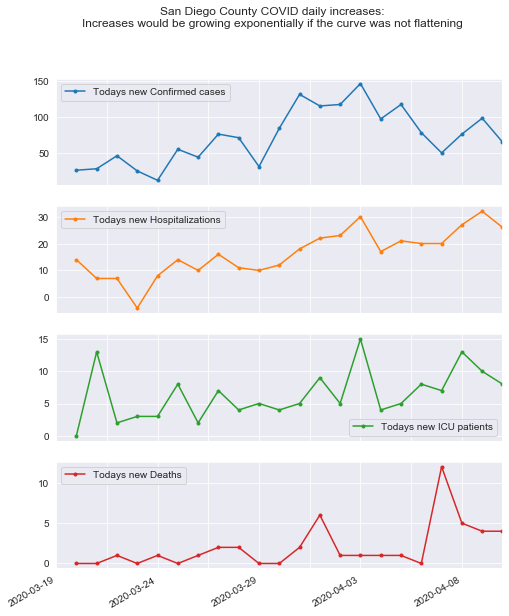

In [364]:
# Obviously the first date (20th or 21st depending on metric) is ignorable because it contains all previous days
# Also I'm pretty sure the -5 hospitalizations on 23rd indicates that some data reclassification happened that day, not that some people were cured and walked out of hospital.
totals.diff().rename(lambda x: 'Todays new '+x, axis='columns').plot(subplots=True,sharex=True,figsize=(8,10),marker='.');
plt.suptitle('San Diego County COVID daily increases:\nIncreases would be growing exponentially if the curve was not flattening')
plt.savefig('Plots/cdeltas.png',dpi=300);

## Is social distancing helping control SD's outbreak?

Doubling time is the # of days for the number of cases/hospitalizations/icu patients to double.  Because each one is a different measurement, I'm calculating doubling tiem seperately in each case.

Now that there is at least one week of data for hospitalizations and icu usage, I feel like we can start to trust a doubling time estimate, and look for changes of doubling time to indicate changes in the progression of the outbreak.  Right now I'm using a sliding 7 day window to see how the doubling time is changing day to day.  I would probably rather have something more like a 10 day window (~ 2 doubling periods) to get a less noisy estimate but we dont' have that much data yet.

Right now I'm using t-statistic estimated 95% confidence intervals on the exponential fit.  Seems as good as any method I can think of, comments from others are welcome.

TL;DR What we want to see if the outbreak is slowing is for the doubling time to get quite a bit bigger.  In spite of the trend of these graphs, at this moment there is no solid evidence of the doubling rate slowing (the doubling time growing)


In [365]:
from scipy.optimize import curve_fit
from scipy.stats.distributions import t

def exfunc(x, a, b):
    return a * np.exp(b * x) 
    
def estimate_doubling_time(data):
    pest, pcov = curve_fit(exfunc, range(len(data)), data)
    doubling_time = np.log(2)/pest[1]
    
    alpha = 0.05 # 95% confidence interval = 100*(1-alpha)
    n = len(data)    # number of data points
    p = len(pest) # number of parameters
    dof = max(0, n - p) # number of degrees of freedom
    # student-t value for the dof and confidence level
    tval = t.ppf(1.0-alpha/2., dof) 
    sigmas = np.power( np.diag(pcov), 0.5)
    
    # this is the exponential param's stdev * Student's t correction for small N
    # we also have to convert exponetial param to doubling time
    ci95 = (np.log(2)/(pest[1]-sigmas[1]) - doubling_time)*tval 
    print('t:{:4.3f} p0:[{:4.3f}+/-{:4.3f}] p1:[{:4.3f}+/-{:4.3f}] dtime:{:4.3f}+/-{:4.3f}'.format(
        tval, pest[0], sigmas[0], pest[1], sigmas[1], doubling_time, ci95))
    
    return(doubling_time, ci95, pest, pcov)

def days_to_value(pest, y):
    '''
    pest = [a, b]
    y = a * exp( b * x )
    ln(y) - ln(a) = b * x
    x = ( ln(y) - ln(a) ) / b
    '''
    return (np.log(y) - np.log(pest[0]))/pest[1]



t:2.571 p0:[163.419+/-6.718] p1:[0.152+/-0.009] dtime:4.558+/-0.748
t:2.571 p0:[189.203+/-7.006] p1:[0.156+/-0.008] dtime:4.449+/-0.634
t:2.571 p0:[223.507+/-9.631] p1:[0.147+/-0.010] dtime:4.725+/-0.853
t:2.571 p0:[260.191+/-10.238] p1:[0.143+/-0.009] dtime:4.857+/-0.823
t:2.571 p0:[301.414+/-10.366] p1:[0.145+/-0.008] dtime:4.779+/-0.688
t:2.571 p0:[346.973+/-10.666] p1:[0.148+/-0.007] dtime:4.694+/-0.588
t:2.571 p0:[405.719+/-10.605] p1:[0.145+/-0.006] dtime:4.781+/-0.517
t:2.571 p0:[466.635+/-10.257] p1:[0.146+/-0.005] dtime:4.764+/-0.428
t:2.571 p0:[546.515+/-16.961] p1:[0.137+/-0.007] dtime:5.046+/-0.697
t:2.571 p0:[653.222+/-21.106] p1:[0.123+/-0.007] dtime:5.656+/-0.938
t:2.571 p0:[779.091+/-23.922] p1:[0.104+/-0.007] dtime:6.686+/-1.288
t:2.571 p0:[907.715+/-30.874] p1:[0.085+/-0.008] dtime:8.137+/-2.231
t:2.571 p0:[1032.789+/-29.127] p1:[0.070+/-0.007] dtime:9.918+/-2.820
t:2.571 p0:[1146.901+/-17.591] p1:[0.059+/-0.004] dtime:11.659+/-2.073
t:2.571 p0:[1241.277+/-13.384] p1:

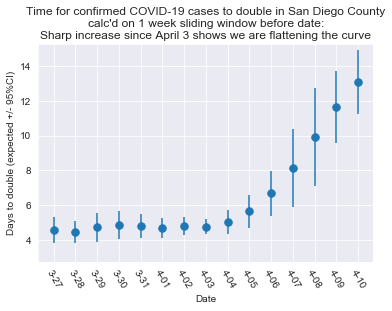

In [366]:

# So the 27th is the first date I'd trust since that elimantes the big delta of the 1st data point on the 20th.

start_calc = '2020-03-27'
ex = []
er = []
ix = []

# calc doubling time in a sliding window backwards 1 week for each day
for day in cases[start_calc:].index:
    todate = day
    fromdate = (pd.Timestamp(day)-pd.Timedelta('6 days')).isoformat().split('T')[0]
    doubling_time, ci95, case_p_est, case_p_cov = estimate_doubling_time(cases[fromdate:todate])
    ex.append( doubling_time )
    er.append( ci95 )
    ix.append( day[-4:] )
plt.errorbar( ix, ex, yerr=er, fmt='.', markersize=15)
plt.title('Time for confirmed COVID-19 cases to double in San Diego County\ncalc\'d on 1 week sliding window before date:\nSharp increase since April 3 shows we are flattening the curve')
plt.ylabel('Days to double (expected +/- 95%CI)')
plt.xlabel('Date')
plt.ylim([2.75, 15.25])
plt.xticks(rotation=-60)
plt.savefig('Plots/casedoubling.png',dpi=300);

t:2.306 p0:[170.108+/-6.422] p1:[0.142+/-0.005] dtime:4.869+/-0.442
t:2.306 p0:[194.406+/-6.852] p1:[0.145+/-0.005] dtime:4.767+/-0.393
t:2.306 p0:[220.871+/-6.707] p1:[0.149+/-0.004] dtime:4.659+/-0.320
t:2.306 p0:[256.340+/-6.716] p1:[0.148+/-0.004] dtime:4.678+/-0.277
t:2.306 p0:[301.726+/-6.477] p1:[0.145+/-0.003] dtime:4.765+/-0.236
t:2.306 p0:[360.519+/-10.661] p1:[0.138+/-0.004] dtime:5.025+/-0.368
t:2.306 p0:[430.944+/-14.947] p1:[0.129+/-0.005] dtime:5.378+/-0.505
t:2.306 p0:[513.256+/-23.110] p1:[0.118+/-0.007] dtime:5.883+/-0.812
t:2.306 p0:[609.541+/-33.822] p1:[0.105+/-0.008] dtime:6.633+/-1.330
t:2.306 p0:[722.559+/-37.773] p1:[0.090+/-0.008] dtime:7.690+/-1.743
t:2.306 p0:[839.360+/-34.428] p1:[0.078+/-0.006] dtime:8.886+/-1.852
t:2.306 p0:[953.366+/-31.393] p1:[0.068+/-0.005] dtime:10.228+/-1.997


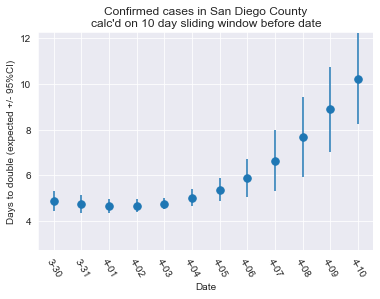

In [367]:


start_calc = '2020-03-30'
ex = []
er = []
ix = []

# calc doubling time in a sliding window backwards 1 week for each day
for day in cases[start_calc:].index:
    todate = day
    fromdate = (pd.Timestamp(day)-pd.Timedelta('9 days')).isoformat().split('T')[0]
    doubling_time, ci95, case_p_est, case_p_cov = estimate_doubling_time(cases[fromdate:todate])
    ex.append( doubling_time )
    er.append( ci95 )
    ix.append( day[-4:] )
plt.errorbar( ix, ex, yerr=er, fmt='.', markersize=15)
plt.title('Confirmed cases in San Diego County\ncalc\'d on 10 day sliding window before date')
plt.ylabel('Days to double (expected +/- 95%CI)')
plt.xlabel('Date')
plt.ylim([2.75, 12.25])
plt.xticks(rotation=-60)
plt.savefig('Plots/casedoubling10day.png',dpi=300);

t:2.571 p0:[30.144+/-2.402] p1:[0.168+/-0.017] dtime:4.130+/-1.228
t:2.571 p0:[34.786+/-2.189] p1:[0.171+/-0.014] dtime:4.042+/-0.901
t:2.571 p0:[41.040+/-2.292] p1:[0.165+/-0.012] dtime:4.191+/-0.860
t:2.571 p0:[51.606+/-2.635] p1:[0.144+/-0.011] dtime:4.827+/-1.075
t:2.571 p0:[62.549+/-1.798] p1:[0.130+/-0.007] dtime:5.321+/-0.723
t:2.571 p0:[72.080+/-1.579] p1:[0.129+/-0.005] dtime:5.373+/-0.556
t:2.571 p0:[82.532+/-1.477] p1:[0.129+/-0.004] dtime:5.369+/-0.450
t:2.571 p0:[91.797+/-1.558] p1:[0.137+/-0.004] dtime:5.064+/-0.375
t:2.571 p0:[105.753+/-2.339] p1:[0.132+/-0.005] dtime:5.254+/-0.535
t:2.571 p0:[123.446+/-3.726] p1:[0.122+/-0.007] dtime:5.698+/-0.887
t:2.571 p0:[144.726+/-4.513] p1:[0.108+/-0.007] dtime:6.427+/-1.200
t:2.571 p0:[167.693+/-4.399] p1:[0.094+/-0.006] dtime:7.349+/-1.341
t:2.571 p0:[189.631+/-3.050] p1:[0.086+/-0.004] dtime:8.066+/-0.980
t:2.571 p0:[209.900+/-1.383] p1:[0.083+/-0.002] dtime:8.366+/-0.422
t:2.571 p0:[227.727+/-1.357] p1:[0.083+/-0.001] dtime:8.

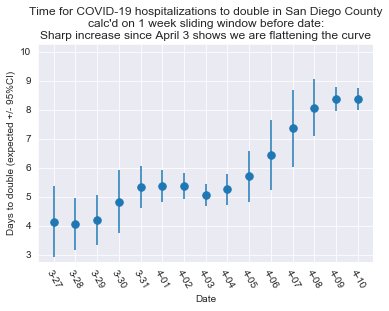

In [368]:
#hospitalizations has a weird negative change on the 23rd, I'm guessing using anything before that will be bad;
# So the 30th is the first date I'd trust

start_calc = '2020-03-27'
ex = []
er = []
ix = []

# calc doubling time in a sliding window backwards 1 week for each day
for day in hospitalizations[start_calc:].index:
    todate = day
    fromdate = (pd.Timestamp(day)-pd.Timedelta('6 days')).isoformat().split('T')[0]
    doubling_time, ci95, hosp_p_est, hosp_p_cov = estimate_doubling_time(hospitalizations[fromdate:todate])
    ex.append( doubling_time )
    er.append( ci95 )
    ix.append( day[-4:] )
plt.errorbar( ix, ex, yerr=er, fmt='.', markersize=15)
plt.title('Time for COVID-19 hospitalizations to double in San Diego County\ncalc\'d on 1 week sliding window before date:\nSharp increase since April 3 shows we are flattening the curve')
plt.ylabel('Days to double (expected +/- 95%CI)')
plt.xlabel('Date')
plt.ylim([2.75, 10.25])
plt.xticks(rotation=-60)
plt.savefig('Plots/hospitaldoubling.png',dpi=300);

t:2.262 p0:[28.099+/-1.639] p1:[0.147+/-0.007] dtime:4.704+/-0.559
t:2.262 p0:[33.414+/-1.740] p1:[0.142+/-0.007] dtime:4.866+/-0.535
t:2.262 p0:[38.692+/-1.756] p1:[0.141+/-0.006] dtime:4.902+/-0.471
t:2.262 p0:[44.511+/-1.747] p1:[0.141+/-0.005] dtime:4.914+/-0.407
t:2.262 p0:[52.198+/-1.443] p1:[0.139+/-0.004] dtime:4.986+/-0.293
t:2.262 p0:[62.588+/-1.473] p1:[0.132+/-0.003] dtime:5.265+/-0.280
t:2.262 p0:[74.037+/-2.110] p1:[0.125+/-0.004] dtime:5.564+/-0.385
t:2.262 p0:[87.386+/-2.923] p1:[0.116+/-0.004] dtime:5.953+/-0.528
t:2.262 p0:[101.662+/-3.930] p1:[0.109+/-0.005] dtime:6.360+/-0.712
t:2.262 p0:[116.927+/-4.430] p1:[0.103+/-0.005] dtime:6.746+/-0.795
t:2.262 p0:[133.350+/-4.316] p1:[0.098+/-0.004] dtime:7.094+/-0.754
t:2.262 p0:[152.120+/-3.851] p1:[0.092+/-0.003] dtime:7.547+/-0.669


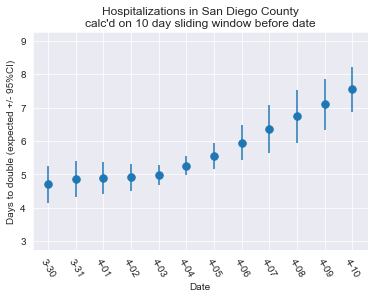

In [369]:

start_calc = '2020-03-30'
ex = []
er = []
ix = []

# calc doubling time in a sliding window backwards 1 week for each day
for day in hospitalizations[start_calc:].index:
    todate = day
    fromdate = (pd.Timestamp(day)-pd.Timedelta('10 days')).isoformat().split('T')[0]
    doubling_time, ci95, hosp_p_est, hosp_p_cov = estimate_doubling_time(hospitalizations[fromdate:todate])
    ex.append( doubling_time )
    er.append( ci95 )
    ix.append( day[-4:] )
plt.errorbar( ix, ex, yerr=er, fmt='.', markersize=15)
plt.title('Hospitalizations in San Diego County\ncalc\'d on 10 day sliding window before date')
plt.ylabel('Days to double (expected +/- 95%CI)')
plt.xlabel('Date')
plt.ylim([2.75, 9.25])
plt.xticks(rotation=-60)
plt.savefig('Plots/hospitaldoubling10day.png',dpi=300);

#### The estimates below are based on all data from March 19, unlike the ones above which are based on a sliding one week window

In [370]:
doubling_time, ci95, case_p_est, case_p_cov  = estimate_doubling_time(cases)
print('Estimating doubling time on confirmed cases data from 2020-03-19 to {}'.format(today))
print('Max likelihood estimate: {:4.3f} days'.format(doubling_time))
print('95% confidence interval: {:4.3f} - {:4.3f} days'.format(doubling_time-ci95, doubling_time+ci95))

t:2.080 p0:[210.685+/-21.545] p1:[0.100+/-0.006] dtime:6.927+/-0.854
Estimating doubling time on confirmed cases data from 2020-03-19 to 2020-04-10
Max likelihood estimate: 6.927 days
95% confidence interval: 6.073 - 7.780 days


In [371]:
doubling_time, ci95, hosp_p_est, hosp_p_cov = estimate_doubling_time(hospitalizations)
print('Estimating doubling time on hospitalizations data from 2020-03-19 to {}'.format(today))
print('Max likelihood estimate: {:4.3f} days'.format(doubling_time))
print('95% confidence interval: {:4.3f} - {:4.3f} days'.format(doubling_time-ci95, doubling_time+ci95))
print(hosp_p_est)

t:2.080 p0:[36.446+/-2.576] p1:[0.109+/-0.004] dtime:6.382+/-0.483
Estimating doubling time on hospitalizations data from 2020-03-19 to 2020-04-10
Max likelihood estimate: 6.382 days
95% confidence interval: 5.898 - 6.865 days
[36.44647487  0.10861738]


In [372]:
doubling_time, ci95, icu_p_est, icu_p_cov = estimate_doubling_time(icu['2020-03-21':])
print('Estimating doubling time on ICU bed data from 2020-03-21 (first day ICU beds recorded) to {}'.format(today))
print('Max likelihood estimate: {:4.3f} days'.format(doubling_time))
print('95% confidence interval: {:4.3f} - {:4.3f} days'.format(doubling_time-ci95, doubling_time+ci95))

t:2.093 p0:[20.859+/-1.172] p1:[0.098+/-0.003] dtime:7.078+/-0.540
Estimating doubling time on ICU bed data from 2020-03-21 (first day ICU beds recorded) to 2020-04-10
Max likelihood estimate: 7.078 days
95% confidence interval: 6.538 - 7.618 days


# The number of available hospital beds
"As of 2018, San Diego had 6,180 total hospital beds. Of those, about 68% were occupied at any given time. That leaves 1,950 beds, including 800 intensive care unit beds, available for new patients." - https://www.kpbs.org/news/2020/mar/20/data-suggests-san-diego-hospitals-will-be-overfill/


Update: In early April the federal government started the process to add 250 beds to the unused upper floors of Palomar Hosptial.  Also in the weeks since the article above, all hospitals have been postponing elective procedures and generally doing what they can to free up beds. You would also expect a lower rate of accidents with the reductions in work and traffic.

I do not have any sources to describe the current number of free beds in San Diego county but I expect it is 100s if not 1000s more than it was when the March 20th article was written.  Things that have happened to increase bed capacity:

- Hospitals have tried to reduce utilization by cancelling elective procedures
- 250 beds are being added to Palomar Hospital on the upper floors in the next weeks
- UCSD has designated an unknown number of beds in their dorms as an alternate site to host recovering COVID patients to free up beds for the people just beginning to get sick

All this will lead me to make two different hospital capacity predictions: 
- an optimistic one that assumes federal hospitals will help (like Navy), a huge increase in free beds based on going from 50% free beds to 70% free beds, and 500 additional beds from Palomar and UCSD.
- a pessimistic one based soley on free SD county beds from March 20th

In [373]:
# Pessimistic number of beds/icu beds available on March 20th from kpbs article above
availbeds = 1950
availicu = 800

# optimistic bed capacity based on 
# 1) all beds including federal beds in navy hospitals (https://www.sandiegouniontribune.com/news/health/story/2020-03-16/regions-hospitals-could-face-thousands-of)
# 2) reduce hospital utilization from 50% to 30% by cancelling procedures
# 3) increase of 250 beds from palomar hospital expansion
# 3) add 250 beds from UCSD alternate care site (WAG from me.  There is no statement on how many beds this would be)
availbedsO = int(8614*.7 + 500)
availbedsO

6529

t:2.080 p0:[210.685+/-21.545] p1:[0.100+/-0.006] dtime:6.927+/-0.854
t:2.080 p0:[36.446+/-2.576] p1:[0.109+/-0.004] dtime:6.382+/-0.483
t:2.093 p0:[20.859+/-1.172] p1:[0.098+/-0.003] dtime:7.078+/-0.540
Hospitals reach capacity on 2020-04-24 15:21:35.193326995
Or optimistically they reach capacity on 2020-05-05 18:22:19.763068759
ICUs reach capacity on 2020-04-27 05:46:53.071938949


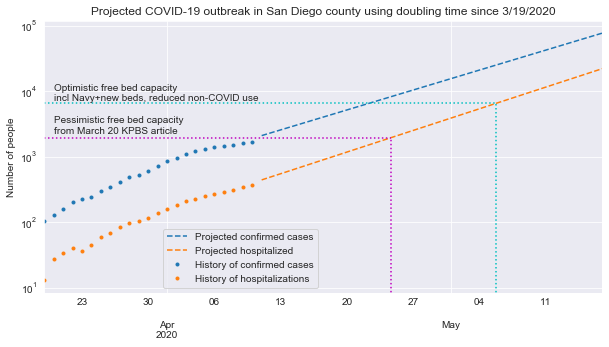

In [374]:
# this projection is based on ALL data from 3/19 onwards
daystoproj = 60
startproj = '2020-03-19'

doubling_time, ci95, case_p_est, case_p_cov  = estimate_doubling_time(cases)
doubling_time, ci95, hosp_p_est, hosp_p_cov = estimate_doubling_time(hospitalizations) 
doubling_time, ci95, icu_p_est, icu_p_cov = estimate_doubling_time(icu['2020-03-21':])
hospital_capacity = days_to_value(hosp_p_est,availbeds)
hospital_capacityO = days_to_value(hosp_p_est,availbedsO)
print('Hospitals reach capacity on {}'.format(pd.Timestamp('2020-03-19') + pd.Timedelta('1 day')*hospital_capacity))

print('Or optimistically they reach capacity on {}'.format(pd.Timestamp('2020-03-19') + pd.Timedelta('1 day')*hospital_capacityO))

icu_capacity = days_to_value(icu_p_est,availicu)
print('ICUs reach capacity on {}'.format(pd.Timestamp('2020-03-21') + pd.Timedelta('1 day')*icu_capacity))




projcases = pd.DataFrame(exfunc(range(0,daystoproj),case_p_est[0],case_p_est[1]),
                        index=pd.date_range(start=startproj,periods=daystoproj)
                        ).astype(int)
projhosp = pd.DataFrame(exfunc(range(0,daystoproj),hosp_p_est[0],hosp_p_est[1]),
                        index=pd.date_range(start=startproj,periods=daystoproj)
                        ).astype(int)

projcases.columns = ['Projected confirmed cases']
projhosp.columns = ['Projected hospitalized']

projected = pd.merge(projcases,projhosp,left_index=True,right_index=True,how='outer')
displayproj = (pd.Timestamp(today)+pd.Timedelta('1 day')).isoformat().split('T')[0]
projected = projected[displayproj:]

actual = pd.merge(cases.rename('History of confirmed cases'), hospitalizations.rename('History of hospitalizations'),left_index=True,right_index=True,how='outer' )
actual.index = pd.DatetimeIndex(actual.index)

fig, ax = plt.subplots(figsize=(10, 5))
projected.plot(title='Projected COVID-19 outbreak in San Diego county using doubling time since 3/19/2020',ax=ax,logy=True,linestyle='--');
actual.plot(ax=ax,logy=True,color=colors,marker='.',linestyle='');


plt.ylabel('Number of people');

xmn = ax.get_xbound()[0]
xmx = (hospital_capacity + xmn)
ymn = 0
ymx = availbeds
ax.plot([xmn, xmx], [ymx,ymx], linestyle=':', color='m')#, alpha=0.5);
ax.plot([xmx, xmx], [ymn,ymx], linestyle=':', color='m')#, alpha=0.5);
ax.annotate('Pessimistic free bed capacity\nfrom March 20 KPBS article',
            xy=(xmn+1, 2300), xycoords='data', fontsize=10);
xmn = ax.get_xbound()[0]
xmx = (hospital_capacityO + xmn)
ymn = 0
ymx = availbedsO
ax.plot([xmn, xmx], [ymx,ymx], linestyle=':', color='c')#, alpha=0.5);
ax.plot([xmx, xmx], [ymn,ymx], linestyle=':', color='c')#, alpha=0.5);
ax.annotate('Optimistic free bed capacity\nincl Navy+new beds, reduced non-COVID use',
            xy=(xmn+1, 7200), xycoords='data', fontsize=10);


plt.legend(loc='best', bbox_to_anchor=(0., 0., 0.5, 0.5))
plt.savefig('Plots/hospitalcapacity.png',dpi=300);

t:2.571 p0:[1241.277+/-13.384] p1:[0.053+/-0.003] dtime:13.073+/-1.825
t:2.571 p0:[227.727+/-1.357] p1:[0.083+/-0.001] dtime:8.353+/-0.380
t:2.571 p0:[87.556+/-1.050] p1:[0.080+/-0.003] dtime:8.713+/-0.853
Hospitals reach capacity on 2020-04-29 21:05:44.004141990
Or optimistically they reach capacity on 2020-05-14 10:36:13.772020219
ICUs reach capacity on 2020-05-01 19:24:46.115054095


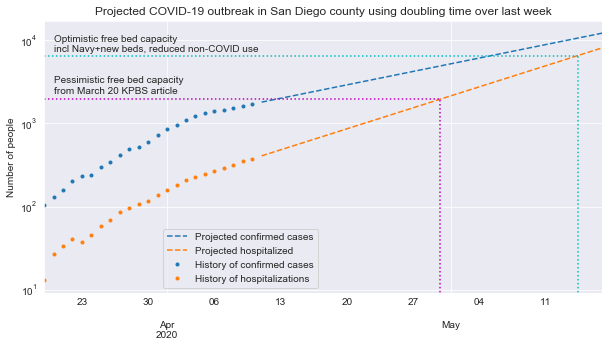

In [375]:
# this projection is based on doubling time calculated only over the last week of data
fromdate = (pd.Timestamp(today)-pd.Timedelta('6 days')).isoformat().split('T')[0]
startproj = (pd.Timestamp(today)+pd.Timedelta('1 day')).isoformat().split('T')[0]
daystoproj = (pd.Timestamp('2020-03-19') + pd.Timedelta('60 days') - pd.Timestamp(fromdate)).days 


doubling_time, ci95, case_p_est, case_p_cov  = estimate_doubling_time(cases[fromdate:])
doubling_time, ci95, hosp_p_est, hosp_p_cov = estimate_doubling_time(hospitalizations[fromdate:]) 
doubling_time, ci95, icu_p_est, icu_p_cov = estimate_doubling_time(icu[fromdate:])
hospital_capacity = days_to_value(hosp_p_est,availbeds)
hospital_capacityO = days_to_value(hosp_p_est,availbedsO)
print('Hospitals reach capacity on {}'.format(pd.Timestamp(fromdate) + pd.Timedelta('1 day')*hospital_capacity))

print('Or optimistically they reach capacity on {}'.format(pd.Timestamp(fromdate) + pd.Timedelta('1 day')*hospital_capacityO))

icu_capacity = days_to_value(icu_p_est, availicu)
print('ICUs reach capacity on {}'.format(pd.Timestamp(fromdate) + pd.Timedelta('1 day')*icu_capacity))




projcases = pd.DataFrame(exfunc(range(0,daystoproj),case_p_est[0],case_p_est[1]),
                        index=pd.date_range(start=fromdate,periods=daystoproj)
                        ).astype(int)
projhosp = pd.DataFrame(exfunc(range(0,daystoproj),hosp_p_est[0],hosp_p_est[1]),
                        index=pd.date_range(start=fromdate,periods=daystoproj)
                        ).astype(int)

projcases.columns = ['Projected confirmed cases']
projhosp.columns = ['Projected hospitalized']

projected = pd.merge(projcases,projhosp,left_index=True,right_index=True,how='outer')
projected = projected[startproj:]

actual = pd.merge(cases.rename('History of confirmed cases'), hospitalizations.rename('History of hospitalizations'),left_index=True,right_index=True,how='outer' )
actual.index = pd.DatetimeIndex(actual.index)

fig, ax = plt.subplots(figsize=(10, 5))
projected.plot(title='Projected COVID-19 outbreak in San Diego county using doubling time over last week',ax=ax,logy=True,linestyle='--');
actual.plot(ax=ax,logy=True,color=colors,marker='.',linestyle='');


plt.ylabel('Number of people');

shiftvline = (pd.Timestamp(fromdate) - pd.Timestamp('2020-03-19')).days
xmn = ax.get_xbound()[0]
xmx = (hospital_capacity + xmn + shiftvline)
ymn = 0
ymx = availbeds
ax.plot([xmn, xmx], [ymx,ymx], linestyle=':', color='m')#, alpha=0.5);
ax.plot([xmx, xmx], [ymn,ymx], linestyle=':', color='m')#, alpha=0.5);
ax.annotate('Pessimistic free bed capacity\nfrom March 20 KPBS article',
            xy=(xmn+1, 2300), xycoords='data', fontsize=10);
xmn = ax.get_xbound()[0]
xmx = (hospital_capacityO + xmn + shiftvline)
ymn = 0
ymx = availbedsO
ax.plot([xmn, xmx], [ymx,ymx], linestyle=':', color='c')#, alpha=0.5);
ax.plot([xmx, xmx], [ymn,ymx], linestyle=':', color='c')#, alpha=0.5);
ax.annotate('Optimistic free bed capacity\nincl Navy+new beds, reduced non-COVID use',
            xy=(xmn+1, 7200), xycoords='data', fontsize=10);


'''plt.axhline(y=availbeds,linestyle=':',color='k');
shiftvline = (pd.Timestamp(fromdate) - pd.Timestamp('2020-03-19')).days
plt.axvline(x=ax.get_xbound()[0] + hospital_capacity + shiftvline, linestyle=':', color='k');
ax.annotate('Hospital free bed capacity based on Mar 20th KPBS article.\nDue to cancelled procedures and increased bed #s\nit will be larger now, but exact # unknown',
            xy=(ax.get_xbound()[0]+1, 2300), xycoords='data', fontsize=10);
ax.annotate('Date hospitals\nrun out of beds',
            xy=(ax.get_xbound()[0] + hospital_capacity + shiftvline + 1 , 20), xycoords='data', fontsize=10);
'''
plt.legend(loc='best', bbox_to_anchor=(0., 0., 0.5, 0.5))
plt.savefig('Plots/hospitalcapacity7day.png',dpi=300);

Calculate exponential parameters on data from 2020-04-04 to 2020-04-10, then project forward using those parameters for 44 days
t:2.571 p0:[1241.277+/-13.384] p1:[0.053+/-0.003] dtime:13.073+/-1.825
t:2.447 p0:[117.793+/-5.873] p1:[0.153+/-0.009] dtime:4.522+/-0.716
t:2.571 p0:[227.727+/-1.357] p1:[0.083+/-0.001] dtime:8.353+/-0.380
t:2.447 p0:[20.756+/-2.468] p1:[0.171+/-0.022] dtime:4.058+/-1.453
t:2.571 p0:[87.556+/-1.050] p1:[0.080+/-0.003] dtime:8.713+/-0.853
Before social distancing had enough time to work, hospitals were projected to reach capacity on 2020-04-15 14:19:38.844414724
Now I think hospitals reach capacity on 2020-04-29 21:05:44.004141990
Or optimistically they reach capacity on 2020-05-14 10:36:13.772020219
ICUs reach capacity on 2020-05-01 19:24:46.115054095


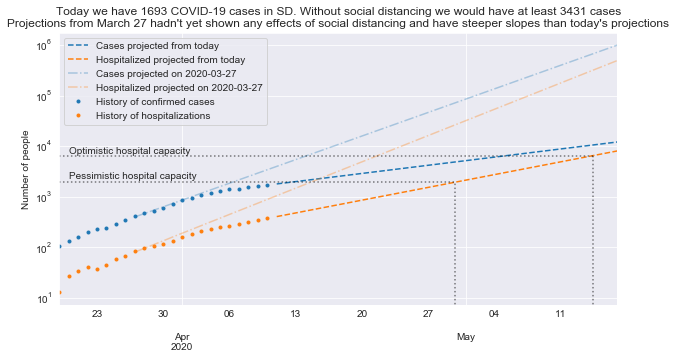

In [376]:
# this projection is based on doubling time calculated only over the last week of data
fromdate = (pd.Timestamp(today)-pd.Timedelta('6 days')).isoformat().split('T')[0]
startproj = (pd.Timestamp(today)+pd.Timedelta('1 day')).isoformat().split('T')[0]
daystoproj = (pd.Timestamp('2020-03-19') + pd.Timedelta('60 days') - pd.Timestamp(fromdate)).days 
print('Calculate exponential parameters on data from {} to {}, then project forward using those parameters for {} days'.format(fromdate,today,daystoproj))

doubling_time, ci95, case_p_est, case_p_cov  = estimate_doubling_time(cases[fromdate:])
doubling_time, ci95, orig_case_p_est, orig_case_p_cov  = estimate_doubling_time(cases['2020-03-19':'2020-03-26'])
doubling_time, ci95, hosp_p_est, hosp_p_cov = estimate_doubling_time(hospitalizations[fromdate:]) 
doubling_time, ci95, orig_hosp_p_est, orig_hosp_p_cov = estimate_doubling_time(hospitalizations['2020-03-19':'2020-03-26'])
doubling_time, ci95, icu_p_est, icu_p_cov = estimate_doubling_time(icu[fromdate:])
hospital_capacity = days_to_value(hosp_p_est,availbeds)
hospital_capacityO = days_to_value(hosp_p_est,availbedsO)
orig_hospital_capacity = days_to_value(orig_hosp_p_est,availbeds)
print('Before social distancing had enough time to work, hospitals were projected to reach capacity on {}'.format(pd.Timestamp('2020-03-20') + pd.Timedelta('1 day')*orig_hospital_capacity))

print('Now I think hospitals reach capacity on {}'.format(pd.Timestamp(fromdate) + pd.Timedelta('1 day')*hospital_capacity))

print('Or optimistically they reach capacity on {}'.format(pd.Timestamp(fromdate) + pd.Timedelta('1 day')*hospital_capacityO))

icu_capacity = days_to_value(icu_p_est, availicu)
print('ICUs reach capacity on {}'.format(pd.Timestamp(fromdate) + pd.Timedelta('1 day')*icu_capacity))




projcases = pd.DataFrame(exfunc(range(0,daystoproj),case_p_est[0],case_p_est[1]),
                        index=pd.date_range(start=fromdate,periods=daystoproj)
                        ).astype(int)
projhosp = pd.DataFrame(exfunc(range(0,daystoproj),hosp_p_est[0],hosp_p_est[1]),
                        index=pd.date_range(start=fromdate,periods=daystoproj)
                        ).astype(int)

projcases.columns = ['Cases projected from today']
projhosp.columns = ['Hospitalized projected from today']

projected = pd.merge(projcases,projhosp,left_index=True,right_index=True,how='outer')
projected = projected[startproj:]

orig_projcases = pd.DataFrame(exfunc(range(0,60),orig_case_p_est[0],orig_case_p_est[1]),
                        index=pd.date_range(start='2020-03-19',periods=60)
                        ).astype(int)
orig_projhosp = pd.DataFrame(exfunc(range(0,60),orig_hosp_p_est[0],orig_hosp_p_est[1]),
                        index=pd.date_range(start='2020-03-19',periods=60)
                        ).astype(int)

orig_projcases.columns = ['Cases projected on 2020-03-27']
orig_projhosp.columns = ['Hospitalized projected on 2020-03-27']

orig_projected = pd.merge(orig_projcases,orig_projhosp,left_index=True,right_index=True,how='outer')
orig_projected = orig_projected['2020-03-27':]


actual = pd.merge(cases.rename('History of confirmed cases'), hospitalizations.rename('History of hospitalizations'),left_index=True,right_index=True,how='outer' )
actual.index = pd.DatetimeIndex(actual.index)

fig, ax = plt.subplots(figsize=(10, 5))
projected.plot(title='Today we have {} COVID-19 cases in SD. Without social distancing we would have at least {} cases\nProjections from March 27 hadn\'t yet shown any effects of social distancing and have steeper slopes than today\'s projections'.format(
     actual.loc[today,'History of confirmed cases'], orig_projected.loc[today,'Cases projected on 2020-03-27']),ax=ax,logy=True,linestyle='--');
orig_projected.plot(ax=ax,logy=True,color=colors,linestyle='-.',alpha=0.33)
actual.plot(ax=ax,logy=True,color=colors,marker='.',linestyle='');


plt.ylabel('Number of people');

shiftvline = (pd.Timestamp(fromdate) - pd.Timestamp('2020-03-19')).days
xmn = ax.get_xbound()[0]
xmx = (hospital_capacity + xmn + shiftvline)
ymn = 0
ymx = availbeds
ax.plot([xmn, xmx], [ymx,ymx], linestyle=':', color='k', alpha=0.5);
ax.plot([xmx, xmx], [ymn,ymx], linestyle=':', color='k', alpha=0.5);
ax.annotate('Pessimistic hospital capacity',
            xy=(xmn+1, 2300), xycoords='data', fontsize=10);
xmn = ax.get_xbound()[0]
xmx = (hospital_capacityO + xmn + shiftvline)
ymn = 0
ymx = availbedsO
ax.plot([xmn, xmx], [ymx,ymx], linestyle=':', color='k', alpha=0.5);
ax.plot([xmx, xmx], [ymn,ymx], linestyle=':', color='k', alpha=0.5);
ax.annotate('Optimistic hospital capacity',
            xy=(xmn+1, 7200), xycoords='data', fontsize=10);

plt.legend(loc='best')#, bbox_to_anchor=(0., .5, 1., 0.5))
plt.savefig('Plots/hospitalcapacity-compare.png',dpi=300);

Calculate exponential parameters on data from 2020-04-04 to 2020-04-10, then project forward using those parameters for 34 days
Compare with exponential parameters fit on data from 2020-03-19 to 2020-03-26
t:2.571 p0:[1241.277+/-13.384] p1:[0.053+/-0.003] dtime:13.073+/-1.825
t:2.447 p0:[117.793+/-5.873] p1:[0.153+/-0.009] dtime:4.522+/-0.716
t:2.571 p0:[227.727+/-1.357] p1:[0.083+/-0.001] dtime:8.353+/-0.380
t:2.447 p0:[20.756+/-2.468] p1:[0.171+/-0.022] dtime:4.058+/-1.453
t:2.571 p0:[87.556+/-1.050] p1:[0.080+/-0.003] dtime:8.713+/-0.853
Before social distancing had enough time to work, hospitals were projected to reach capacity on 2020-04-15 14:19:38.844414724
Now I pessimistically think hospitals reach capacity on 2020-04-29 21:05:44.004141990
Or now I optimistically think they reach capacity on 2020-05-14 10:36:13.772020219
Now I think ICUs reach capacity on 2020-05-01 19:24:46.115054095


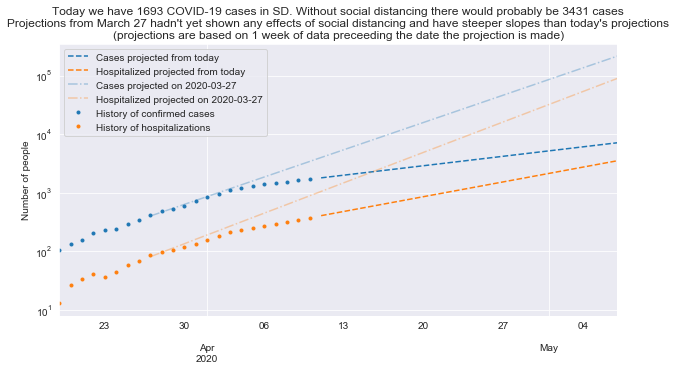

In [377]:
# this projection is based on doubling time calculated only over the last week of data
daysfwd = 50

fromdate = (pd.Timestamp(today)-pd.Timedelta('6 days')).isoformat().split('T')[0]
startproj = (pd.Timestamp(today)+pd.Timedelta('1 day')).isoformat().split('T')[0]
daystoproj = (pd.Timestamp('2020-03-19') + pd.Timedelta('{} days'.format(daysfwd)) - pd.Timestamp(fromdate)).days 
print('Calculate exponential parameters on data from {} to {}, then project forward using those parameters for {} days'.format(fromdate,today,daystoproj))
print('Compare with exponential parameters fit on data from 2020-03-19 to 2020-03-26')


doubling_time, ci95, case_p_est, case_p_cov  = estimate_doubling_time(cases[fromdate:])
doubling_time, ci95, orig_case_p_est, orig_case_p_cov  = estimate_doubling_time(cases['2020-03-19':'2020-03-26'])
doubling_time, ci95, hosp_p_est, hosp_p_cov = estimate_doubling_time(hospitalizations[fromdate:]) 
doubling_time, ci95, orig_hosp_p_est, orig_hosp_p_cov = estimate_doubling_time(hospitalizations['2020-03-19':'2020-03-26'])
doubling_time, ci95, icu_p_est, icu_p_cov = estimate_doubling_time(icu[fromdate:])
hospital_capacity = days_to_value(hosp_p_est,availbeds)
hospital_capacityO = days_to_value(hosp_p_est,availbedsO)
orig_hospital_capacity = days_to_value(orig_hosp_p_est,availbeds)
print('Before social distancing had enough time to work, hospitals were projected to reach capacity on {}'.format(pd.Timestamp('2020-03-20') + pd.Timedelta('1 day')*orig_hospital_capacity))

print('Now I pessimistically think hospitals reach capacity on {}'.format(pd.Timestamp(fromdate) + pd.Timedelta('1 day')*hospital_capacity))

print('Or now I optimistically think they reach capacity on {}'.format(pd.Timestamp(fromdate) + pd.Timedelta('1 day')*hospital_capacityO))

icu_capacity = days_to_value(icu_p_est, availicu)
print('Now I think ICUs reach capacity on {}'.format(pd.Timestamp(fromdate) + pd.Timedelta('1 day')*icu_capacity))




projcases = pd.DataFrame(exfunc(range(0,daystoproj),case_p_est[0],case_p_est[1]),
                        index=pd.date_range(start=fromdate,periods=daystoproj)
                        ).astype(int)
projhosp = pd.DataFrame(exfunc(range(0,daystoproj),hosp_p_est[0],hosp_p_est[1]),
                        index=pd.date_range(start=fromdate,periods=daystoproj)
                        ).astype(int)

projcases.columns = ['Cases projected from today']
projhosp.columns = ['Hospitalized projected from today']

projected = pd.merge(projcases,projhosp,left_index=True,right_index=True,how='outer')
projected = projected[startproj:]

orig_projcases = pd.DataFrame(exfunc(range(0,daysfwd),orig_case_p_est[0],orig_case_p_est[1]),
                        index=pd.date_range(start='2020-03-19',periods=daysfwd)
                        ).astype(int)
orig_projhosp = pd.DataFrame(exfunc(range(0,daysfwd),orig_hosp_p_est[0],orig_hosp_p_est[1]),
                        index=pd.date_range(start='2020-03-19',periods=daysfwd)
                        ).astype(int)

orig_projcases.columns = ['Cases projected on 2020-03-27']
orig_projhosp.columns = ['Hospitalized projected on 2020-03-27']

orig_projected = pd.merge(orig_projcases,orig_projhosp,left_index=True,right_index=True,how='outer')
orig_projected = orig_projected['2020-03-27':]


actual = pd.merge(cases.rename('History of confirmed cases'), hospitalizations.rename('History of hospitalizations'),left_index=True,right_index=True,how='outer' )
actual.index = pd.DatetimeIndex(actual.index)

fig, ax = plt.subplots(figsize=(10, 5))
projected.plot(
    title=('Today we have {} COVID-19 cases in SD. Without social distancing there would probably be {} cases\n' + 
    'Projections from March 27 hadn\'t yet shown any effects of social distancing and have steeper slopes than today\'s projections\n' +
    '(projections are based on 1 week of data preceeding the date the projection is made)').format(
     actual.loc[today,'History of confirmed cases'], 
        orig_projected.loc[today,'Cases projected on 2020-03-27'])
    ,ax=ax,logy=True,linestyle='--');
orig_projected.plot(ax=ax,logy=True,color=colors,linestyle='-.',alpha=0.33)
actual.plot(ax=ax,logy=True,color=colors,marker='.',linestyle='');


plt.ylabel('Number of people');


plt.legend(loc='best')#, bbox_to_anchor=(0., .5, 1., 0.5))
plt.savefig('Plots/socialdistancing.png',dpi=300);

Calculate exponential parameters on data from 2020-04-04 to 2020-04-10, then project forward using those parameters for 20 days
Compare with exponential parameters fit on data from 2020-03-19 to 2020-03-26
t:2.571 p0:[1241.277+/-13.384] p1:[0.053+/-0.003] dtime:13.073+/-1.825
t:2.447 p0:[117.793+/-5.873] p1:[0.153+/-0.009] dtime:4.522+/-0.716
t:2.571 p0:[227.727+/-1.357] p1:[0.083+/-0.001] dtime:8.353+/-0.380
t:2.447 p0:[20.756+/-2.468] p1:[0.171+/-0.022] dtime:4.058+/-1.453
t:2.571 p0:[87.556+/-1.050] p1:[0.080+/-0.003] dtime:8.713+/-0.853
Before social distancing had enough time to work, hospitals were projected to reach capacity on 2020-04-15 14:19:38.844414724
Now I pessimistically think hospitals reach capacity on 2020-04-29 21:05:44.004141990
Or now I optimistically think they reach capacity on 2020-05-14 10:36:13.772020219
Now I think ICUs reach capacity on 2020-05-01 19:24:46.115054095


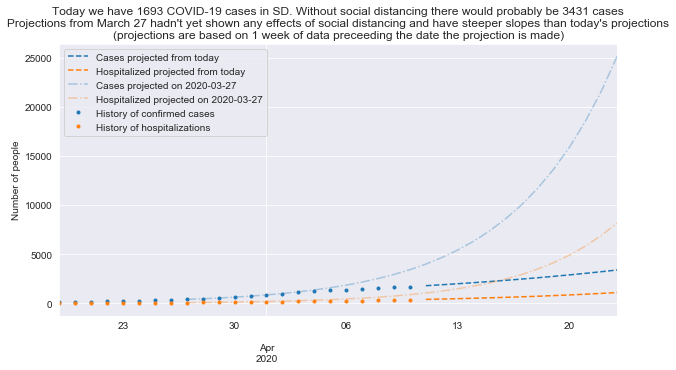

In [381]:
# this projection is based on doubling time calculated only over the last week of data
daysfwd = 36

fromdate = (pd.Timestamp(today)-pd.Timedelta('6 days')).isoformat().split('T')[0]
startproj = (pd.Timestamp(today)+pd.Timedelta('1 day')).isoformat().split('T')[0]
daystoproj = (pd.Timestamp('2020-03-19') + pd.Timedelta('{} days'.format(daysfwd)) - pd.Timestamp(fromdate)).days 
print('Calculate exponential parameters on data from {} to {}, then project forward using those parameters for {} days'.format(fromdate,today,daystoproj))
print('Compare with exponential parameters fit on data from 2020-03-19 to 2020-03-26')


doubling_time, ci95, case_p_est, case_p_cov  = estimate_doubling_time(cases[fromdate:])
doubling_time, ci95, orig_case_p_est, orig_case_p_cov  = estimate_doubling_time(cases['2020-03-19':'2020-03-26'])
doubling_time, ci95, hosp_p_est, hosp_p_cov = estimate_doubling_time(hospitalizations[fromdate:]) 
doubling_time, ci95, orig_hosp_p_est, orig_hosp_p_cov = estimate_doubling_time(hospitalizations['2020-03-19':'2020-03-26'])
doubling_time, ci95, icu_p_est, icu_p_cov = estimate_doubling_time(icu[fromdate:])
hospital_capacity = days_to_value(hosp_p_est,availbeds)
hospital_capacityO = days_to_value(hosp_p_est,availbedsO)
orig_hospital_capacity = days_to_value(orig_hosp_p_est,availbeds)
print('Before social distancing had enough time to work, hospitals were projected to reach capacity on {}'.format(pd.Timestamp('2020-03-20') + pd.Timedelta('1 day')*orig_hospital_capacity))

print('Now I pessimistically think hospitals reach capacity on {}'.format(pd.Timestamp(fromdate) + pd.Timedelta('1 day')*hospital_capacity))

print('Or now I optimistically think they reach capacity on {}'.format(pd.Timestamp(fromdate) + pd.Timedelta('1 day')*hospital_capacityO))

icu_capacity = days_to_value(icu_p_est, availicu)
print('Now I think ICUs reach capacity on {}'.format(pd.Timestamp(fromdate) + pd.Timedelta('1 day')*icu_capacity))




projcases = pd.DataFrame(exfunc(range(0,daystoproj),case_p_est[0],case_p_est[1]),
                        index=pd.date_range(start=fromdate,periods=daystoproj)
                        ).astype(int)
projhosp = pd.DataFrame(exfunc(range(0,daystoproj),hosp_p_est[0],hosp_p_est[1]),
                        index=pd.date_range(start=fromdate,periods=daystoproj)
                        ).astype(int)

projcases.columns = ['Cases projected from today']
projhosp.columns = ['Hospitalized projected from today']

projected = pd.merge(projcases,projhosp,left_index=True,right_index=True,how='outer')
projected = projected[startproj:]

orig_projcases = pd.DataFrame(exfunc(range(0,daysfwd),orig_case_p_est[0],orig_case_p_est[1]),
                        index=pd.date_range(start='2020-03-19',periods=daysfwd)
                        ).astype(int)
orig_projhosp = pd.DataFrame(exfunc(range(0,daysfwd),orig_hosp_p_est[0],orig_hosp_p_est[1]),
                        index=pd.date_range(start='2020-03-19',periods=daysfwd)
                        ).astype(int)

orig_projcases.columns = ['Cases projected on 2020-03-27']
orig_projhosp.columns = ['Hospitalized projected on 2020-03-27']

orig_projected = pd.merge(orig_projcases,orig_projhosp,left_index=True,right_index=True,how='outer')
orig_projected = orig_projected['2020-03-27':]


actual = pd.merge(cases.rename('History of confirmed cases'), hospitalizations.rename('History of hospitalizations'),left_index=True,right_index=True,how='outer' )
actual.index = pd.DatetimeIndex(actual.index)

fig, ax = plt.subplots(figsize=(10, 5))
projected.plot(
    title=('Today we have {} COVID-19 cases in SD. Without social distancing there would probably be {} cases\n' + 
    'Projections from March 27 hadn\'t yet shown any effects of social distancing and have steeper slopes than today\'s projections\n' +
    '(projections are based on 1 week of data preceeding the date the projection is made)').format(
     actual.loc[today,'History of confirmed cases'], 
        orig_projected.loc[today,'Cases projected on 2020-03-27'])
    ,ax=ax,linestyle='--');
orig_projected.plot(ax=ax,color=colors,linestyle='-.',alpha=0.33)
actual.plot(ax=ax,color=colors,marker='.',linestyle='');


plt.ylabel('Number of people');


plt.legend(loc='best')#, bbox_to_anchor=(0., .5, 1., 0.5))
plt.savefig('Plots/socialdistancing-nonlog.png',dpi=300);

# but all this might be moot...
because I ran this by two people who actually know stuff, unlike me.

My summary: Hospitals could be stressed and not dealing well with the infected as soon as they have a couple of patients.  They will then adjust and just make-do as best they can, shutting down services, moving resources from here to there as much as they can.  These decisions will be made differently by each hospital so there's really no way to predict hospital capacity.  

Perhaps you can see my capacity limit as an upper limit... that is the hospital system in San Diego will likely be in crisis well before my estimate of late April (**NB: originally this was mid April, but doubling time is slowing now!)**  

To read the actual exchange, which took place on March 26th, see below

--Jason



Gerald Pao, an MD/PhD who's worked in virology... 

>Although this is a reasonable estimate at face value it does not take into account how a hospital works
You cannot have the highly contagious population in the same space as the rest of the patients who are there for other reasons.
So you need to ask how many barrier nursing negative pressure beds does the hospital have?
The answer is for any normal hospital the number of beds is between 5-10
I have asked my friends in CA  from the Bay area, LA and SD and no one has given me a number higher than 10
This means people will have to designate hospital wings to this task and somehow separate things. 
In places in Spain and Italy they sometimes designated particular hospitals for this task or had the ER designated for it and rearranged it.
In other ones they had particular floors closed off etc.
so the real capacity will depend on what the hospital administrators decide to do and will be made in uneven and unpredictable ways as there is no single set of rules on how to manage this.
Therefore the pressure on hospitals and when you will be out of capacity will be difficult to estimate. We do not have a national healthcare system as you know so it’s gonna be a a free for all.
>
>Gerald Pao 
>
>The Salk Institute for Biological Studies


Joel Wertheim, a bioinformatician who specializes in the evolution and epidemiology of HIV...  

>Hi Jason,
>
>Interesting  stuff.
>
>Another point to consider in the general design is the time-lag between all of these states. Most people are not admitted to the hospital for quite some time after infection. If they proceed to the ICU and/or death, that also can take weeks after initial infection/diagnosis. I’m not sure of the proportion of cases in San Diego diagnosed after admittance to the hospital, as opposed to be people who aren't (yet) sick enough to be hospitalized. 
>
>Also, at UC San Diego, negative pressure rooms were originally used for COVID patients (back when we were treating the first patients brought back from China). Now, they are just being used for procedures that would result in high likelihood of spread (i.e., intubation). So the number of beds can change with the severity of the epidemic (as Gerald also mentioned).
>
>Cheers,
>
>Joel  
>
>University of California San Diego



# Here is a maybe-better resource on this topic than my model….  It projects bed, ICU, and ventilator usage for US and all 50 states separately 

Interactive visualization
https://covid19.healthdata.org/projections

Arxiv paper:
http://www.healthdata.org/sites/default/files/files/research_articles/2020/covid_paper_MEDRXIV-2020-043752v1-Murray.pdf


And here is some sharp criticism of the model above from an excellent source (the creator of the course "Calling Bullshit on Big Data").  TLDR; The model is making some strong assumptions that may not be warranted:
https://twitter.com/CT_Bergstrom/status/1244815009303023616

For posterity and to compare the outcome with the projections, I'm putting screen shots of this model's predictions for USA and CA into this notebook (collected on the evening of March 26 2020).  Particularly I'm interested in teh 95% confidecne interval values and comparing the results in July with what these models were saying now


![USA prediction hospitalizations](Images/USA-prediction-hospital.png "USA prediction hospitalizations")

![USA prediction deaths](Images/USA-prediction-deaths.png "USA prediction deaths")

![CA prediction hospitalizations](Images/CA-prediction-hospital.png "USA prediction hospitalizations")

![CA prediction deaths](Images/CA-prediction-deaths.png "CA prediction deaths")

### Below this is just some stuff I started to scrape the location data... 
But TBH I now think this is useless... there's no way the location of infection is useful except as a proxy for which hospitals are most burdened.

Certainly you wouldn't want to say something like "Oh this is were you can catch the virus the best..." That's some BS because there is 1) unknown infected people out there and 2) the location is someone's DMV/voting record of residence, not necessarily where they actually live, hang out, shop, and work. 

In [382]:
# these column locations are hand tuned 
locations = read_pdf('https://www.sandiegocounty.gov/content/dam/sdc/hhsa/programs/phs/Epidemiology/COVID-19%20Daily%20Update_City%20of%20Residence.pdf', options="--columns 250.0,375.0", guess=False)

In [383]:
# because I'm not parsing the date out of the pdf, you should manually make sure this has been updated too before scraping!
# 3/25 version
'''locations = locations.set_index('County of San Diego')
locations = locations['San Diego County':'OVERALL TOTAL'].dropna()
locations.columns = locations.loc['San Diego County',:]
locations = locations.drop('San Diego County')
locations.to_csv(locf.format(today))
print(today)
locations'''
None;

In [384]:
# because I'm not parsing the date out of the pdf, you should manually make sure this has been updated too before scraping!
# 3/26 version
locations = locations.set_index('County of San Diego')
locations = locations['San Diego County':'Total San Diego County Residents'].dropna()
locations.columns = locations.loc['San Diego County',:]
locations = locations.drop('San Diego County')
locations.to_csv(locf.format(today))
print(today)
locations

2020-04-10


San Diego County,Count,Percentage** of Overall Total
County of San Diego,,
Incorporated City,"1,464",86.5%
Carlsbad,48,2.8%
Chula Vista,163,9.6%
Coronado,5,0.3%
Del Mar,8,0.5%
El Cajon,97,5.7%
Encinitas,33,1.9%
Escondido,46,2.7%
Imperial Beach,10,0.6%


In [388]:
zips = read_pdf('https://www.sandiegocounty.gov/content/dam/sdc/hhsa/programs/phs/Epidemiology/COVID-19%20Summary%20of%20Cases%20by%20Zip%20Code.pdf')

In [389]:
# on 4/3 the column read changed a bit, had been .iloc[1,:], now its [0,:]
# on 4/5 its back to .iloc[1,:]
# on 4/7 its back to [0,:]
zips.columns = zips.iloc[0,:] 
zips = zips[1:]
zips = pd.concat([zips.iloc[:,:2], zips.iloc[:,2:]]).set_index('Zip Code').dropna().drop('Unknown*')
zips.to_csv(zipf.format(today))
print(today)
zips

2020-04-10


,Case Count
Zip Code,
91901,1
91902,16
91905,1
91910,44
91911,52
...,...
92139,27
92154,58
92161,2


In [858]:
import requests
import pdfminer

with open('test.pdf','wb') as fp:
    r = requests.get('https://www.sandiegocounty.gov/content/dam/sdc/hhsa/programs/phs/Epidemiology/COVID-19%20Bar%20Graph%20of%20New%20and%20Total%20Cases.pdf')
    fp.write(r.content)

with open('test.pdf','r') as inp:
    outp = open('test.txt','w')
    pdfminer.high_level.extract_text_to_fp(inp,outp)

        

UnicodeDecodeError: 'utf-8' codec can't decode byte 0xb0 in position 3436: invalid start byte

In [ ]:
pdfminer.high_level.